In [1]:
import numpy as np
import pandas as pd

In [51]:
data = pd.read_csv("../datasets/cbecs2018_final_public.csv")

In [52]:
data.head()

,PUBID,REGION,CENDIV,PBA,PUBCLIM,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,...,ZMFBTU,ZMFEXP,ZELCNS,ZELEXP,ZNGCNS,ZNGEXP,ZFKCNS,ZFKEXP,ZDHBTU,ZDHEXP
0,1,3,5,2,3,210000,8,1,4,2,...,0,0,0,0,9,9,1,1,0,0
1,2,4,9,2,4,28000,5,1,6,1,...,0,0,0,0,0,0,9,9,9,9
2,3,3,5,8,4,2100,2,1,4,2,...,0,0,0,0,9,9,9,9,9,9
3,4,3,7,5,5,240000,8,2,6,1,...,0,0,0,0,1,1,9,9,9,9
4,5,1,2,5,3,295000,8,3,6,2,...,0,0,0,0,0,0,9,9,9,9


In [53]:
data.columns

Index(['PUBID', 'REGION', 'CENDIV', 'PBA', 'PUBCLIM', 'SQFT', 'SQFTC', 'WLCNS',
       'RFCNS', 'RFCOOL',
       ...
       'ZMFBTU', 'ZMFEXP', 'ZELCNS', 'ZELEXP', 'ZNGCNS', 'ZNGEXP', 'ZFKCNS',
       'ZFKEXP', 'ZDHBTU', 'ZDHEXP'],
      dtype='object', length=1249)

In [54]:
data.describe()

,PUBID,REGION,CENDIV,PBA,PUBCLIM,SQFT,SQFTC,WLCNS,RFCNS,RFCOOL,...,ZMFBTU,ZMFEXP,ZELCNS,ZELEXP,ZNGCNS,ZNGEXP,ZFKCNS,ZFKEXP,ZDHBTU,ZDHEXP
count,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6.436000e+03,6436.000000,6436.000000,6436.000000,6436.000000,...,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000,6436.000000
mean,3218.500000,2.629739,5.105811,12.564947,3.646830,1.691617e+05,5.611871,2.379273,4.355811,1.501554,...,0.429459,0.449658,0.407085,0.441112,2.871193,2.909571,6.785270,6.804848,8.273928,8.275637
std,1858.057498,1.006943,2.439221,11.937664,1.701329,2.851251e+05,2.304431,1.741901,2.081375,0.500036,...,1.092531,1.093648,1.090856,1.093221,3.978072,3.954940,3.681433,3.647798,2.358672,2.353031
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.001000e+03,2.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1609.750000,2.000000,3.000000,5.000000,2.000000,1.125000e+04,4.000000,1.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,9.000000,9.000000
50%,3218.500000,3.000000,5.000000,13.000000,3.000000,6.900000e+04,6.000000,1.000000,5.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,9.000000,9.000000,9.000000,9.000000
75%,4827.250000,3.000000,7.000000,16.000000,5.000000,2.100000e+05,8.000000,3.000000,6.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
max,6436.000000,4.000000,9.000000,91.000000,7.000000,2.100000e+06,10.000000,8.000000,8.000000,2.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000


In [100]:
columns = ["DATACNTR", "TRNGRM", "STDNRM", "LGOFFDEV", "SMOFFDEV", "SERVER", "LAPTOP", "RFGSTO", "ELCOOL","GOVOWN", "PVC", \
           "PCTERMN", "LAPTPN", "TABLETN","SERVERN", "LGOFFDEVN", "SMOFFDEVN", "WBOARDSN", "COOLP", "DCNTRSFC", "ELEXP"]

In [101]:
df = data[columns]

In [102]:
df.head()

,DATACNTR,TRNGRM,STDNRM,LGOFFDEV,SMOFFDEV,SERVER,LAPTOP,RFGSTO,ELCOOL,GOVOWN,...,PCTERMN,LAPTPN,TABLETN,SERVERN,LGOFFDEVN,SMOFFDEVN,WBOARDSN,COOLP,DCNTRSFC,ELEXP
0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1,1,...,250.0,50.0,NaN,100.0,70.0,NaN,4.0,100.0,4.0,775800.0
1,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1,2,...,20.0,5.0,100.0,1.0,2.0,10.0,NaN,100.0,NaN,77933.0
2,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1,2,...,2.0,5.0,2.0,1.0,NaN,3.0,NaN,100.0,NaN,3472.0
3,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1,2,...,15.0,10.0,NaN,1.0,NaN,9.0,NaN,45.0,NaN,41197.0
4,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2,2,...,10.0,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,33688.0


In [103]:
df.describe()

,DATACNTR,TRNGRM,STDNRM,LGOFFDEV,SMOFFDEV,SERVER,LAPTOP,RFGSTO,ELCOOL,GOVOWN,...,PCTERMN,LAPTPN,TABLETN,SERVERN,LGOFFDEVN,SMOFFDEVN,WBOARDSN,COOLP,DCNTRSFC,ELEXP
count,5793.000000,5793.000000,5793.000000,6314.000000,6314.000000,6314.000000,6314.000000,5416.000000,6436.000000,6436.000000,...,5540.000000,4758.000000,3475.000000,3633.000000,3814.000000,5073.000000,1301.000000,5980.000000,897.000000,6.357000e+03
mean,1.845158,1.776627,1.831348,1.395946,1.196547,1.424612,1.246436,1.957164,1.114201,1.745960,...,173.868773,145.064523,101.355108,84.003303,72.832197,194.022078,118.190623,81.194314,2.147157,2.535272e+05
std,0.361785,0.416542,0.374476,0.489092,0.397419,0.494323,0.430970,0.202506,0.318080,0.435354,...,443.911787,308.190016,235.954625,826.355795,739.630732,1250.707378,953.921298,29.075135,1.277630,5.776407e+05
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.200000e+01
25%,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,...,6.000000,5.000000,5.000000,2.000000,2.000000,4.000000,4.000000,75.000000,1.000000,1.180600e+04
50%,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,...,30.000000,23.000000,20.000000,4.000000,5.000000,10.000000,12.000000,100.000000,2.000000,6.674000e+04
75%,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,...,150.000000,100.000000,99.500000,10.000000,15.000000,30.000000,40.000000,100.000000,3.000000,2.555860e+05
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,3615.000000,1480.000000,1410.000000,9995.000000,9995.000000,9995.000000,9995.000000,100.000000,5.000000,1.487568e+07


In [104]:
missing_values = df.isnull().sum()
print(missing_values)


DATACNTR      643
TRNGRM        643
STDNRM        643
LGOFFDEV      122
SMOFFDEV      122
SERVER        122
LAPTOP        122
RFGSTO       1020
ELCOOL          0
GOVOWN          0
PVC          4137
PCTERMN       896
LAPTPN       1678
TABLETN      2961
SERVERN      2803
LGOFFDEVN    2622
SMOFFDEVN    1363
WBOARDSN     5135
COOLP         456
DCNTRSFC     5539
ELEXP          79
dtype: int64


In [105]:
df = df.dropna(subset=['ELEXP'])

In [106]:
cat_cols = ["DATACNTR", "TRNGRM", "STDNRM", "LGOFFDEV", "SMOFFDEV", "SERVER", "LAPTOP", "RFGSTO", "ELCOOL","GOVOWN", "PVC", ]
cont_cols = ["PCTERMN", "LAPTPN", "TABLETN","SERVERN", "LGOFFDEVN", "SMOFFDEVN", "WBOARDSN", "COOLP", "DCNTRSFC", "ELEXP"]

In [107]:
unique_counts = df[cat_cols].nunique()
print(unique_counts)

DATACNTR    2
TRNGRM      2
STDNRM      2
LGOFFDEV    2
SMOFFDEV    2
SERVER      2
LAPTOP      2
RFGSTO      2
ELCOOL      2
GOVOWN      2
PVC         2
dtype: int64


### Numerical Columns EDA

In [108]:
for col in cont_cols:
    Q1 = df[col].quantile(0.25)  # 25th percentile
    Q3 = df[col].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile range
    
    # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove rows outside the bounds
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

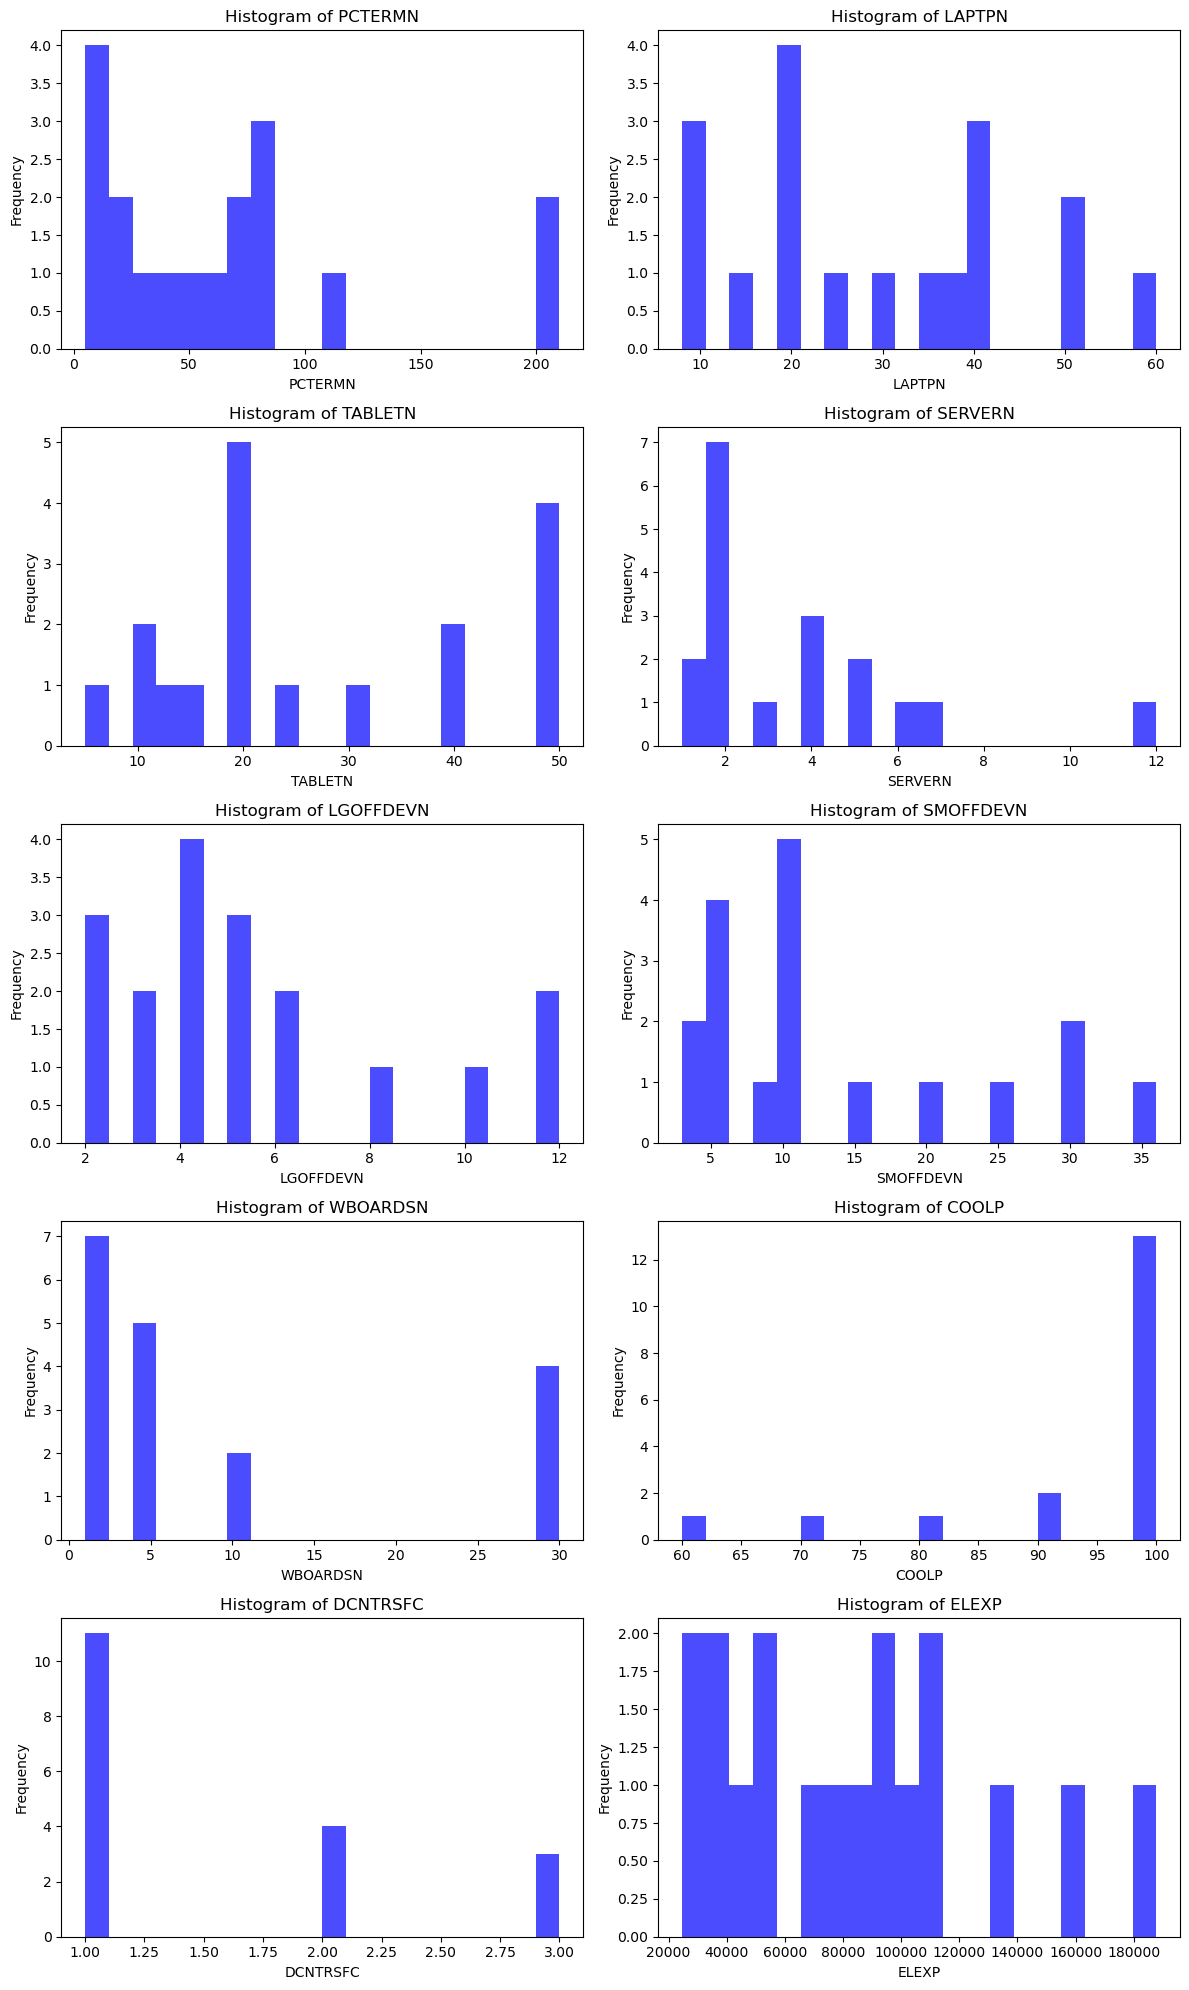

In [109]:
import matplotlib.pyplot as plt


num_cols = len(cont_cols)

# Create subplots
rows = (num_cols + 1) // 2  # Calculate the number of rows needed
fig, axes = plt.subplots(rows, 2, figsize=(12, rows * 4))  # Adjust figure size
axes = axes.flatten()  # Flatten axes for easy iteration

# Plot histograms
for i, col in enumerate(cont_cols):
    axes[i].hist(df[col].dropna(), bins=20, alpha=0.7, color='blue')  # Exclude NA values
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pair plot
sns.pairplot(df[cont_cols], diag_kind='kde', corner=True)  # 'diag_kind' for diagonal plots; 'corner=True' for a lower triangle plot
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


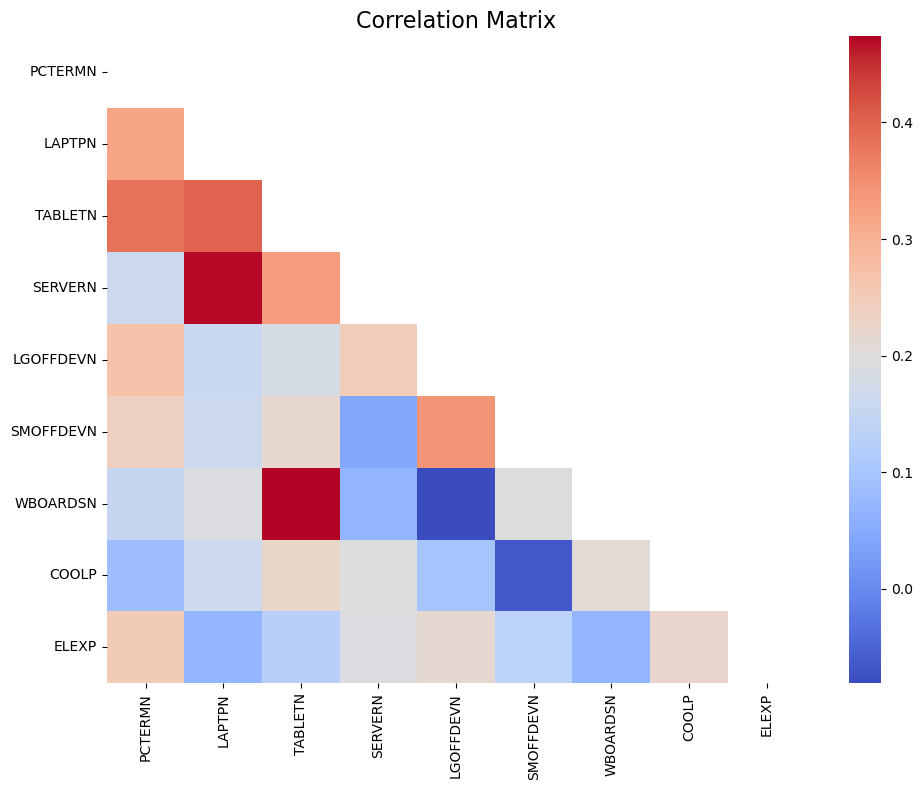

In [86]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Compute the correlation matrix for numerical columns
correlation_matrix = df[cont_cols].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust the size as needed
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, annot_kws={"size": 10})
plt.title("Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()


### Categorical EDA

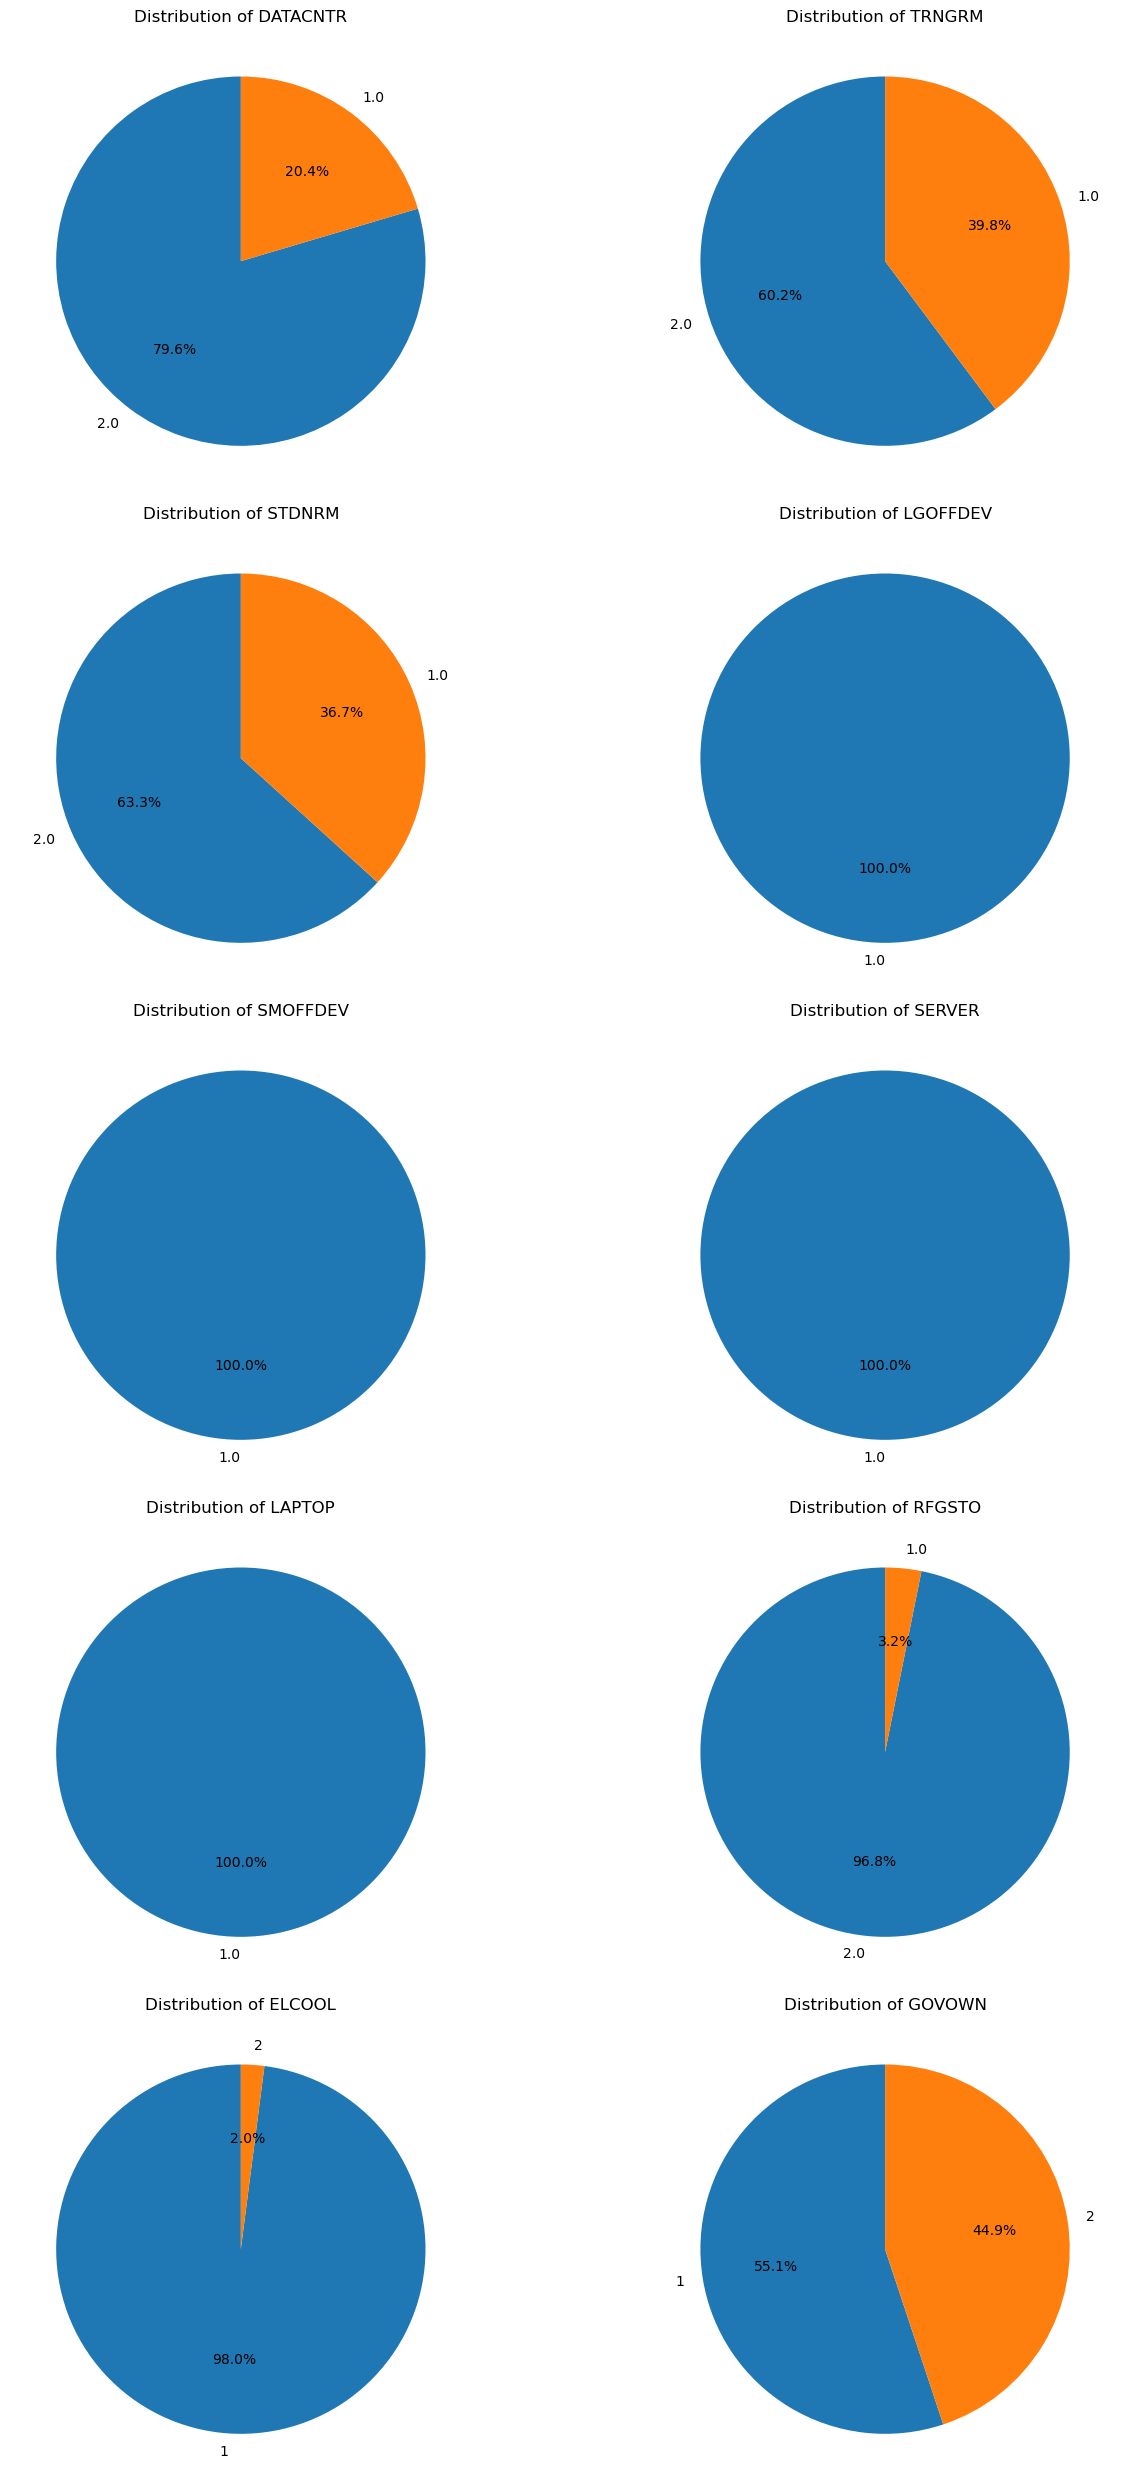

In [87]:
import matplotlib.pyplot as plt



# Determine the number of rows and columns for subplots
n_cols = 2  # Number of pie charts per row
n_rows = (len(cat_cols) + n_cols - 1) // n_cols  # Calculate the number of rows

# Create a subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through each categorical column and plot the pie chart
for i, col in enumerate(cat_cols):
    value_counts = df[col].value_counts(normalize=True) * 100  # Percentage of unique values
    labels = value_counts.index  # Categories as labels
    sizes = value_counts.values  # Percentages as sizes

    axes[i].pie(sizes, labels=labels, autopct="%.1f%%", startangle=90)
    axes[i].set_title(f"Distribution of {col}")

# Remove any extra subplots (if cat_cols < total grid slots)
for j in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [88]:
cat_cols = ["DATACNTR", "TRNGRM", "STDNRM", "RFGSTO", "ELCOOL","GOVOWN"]

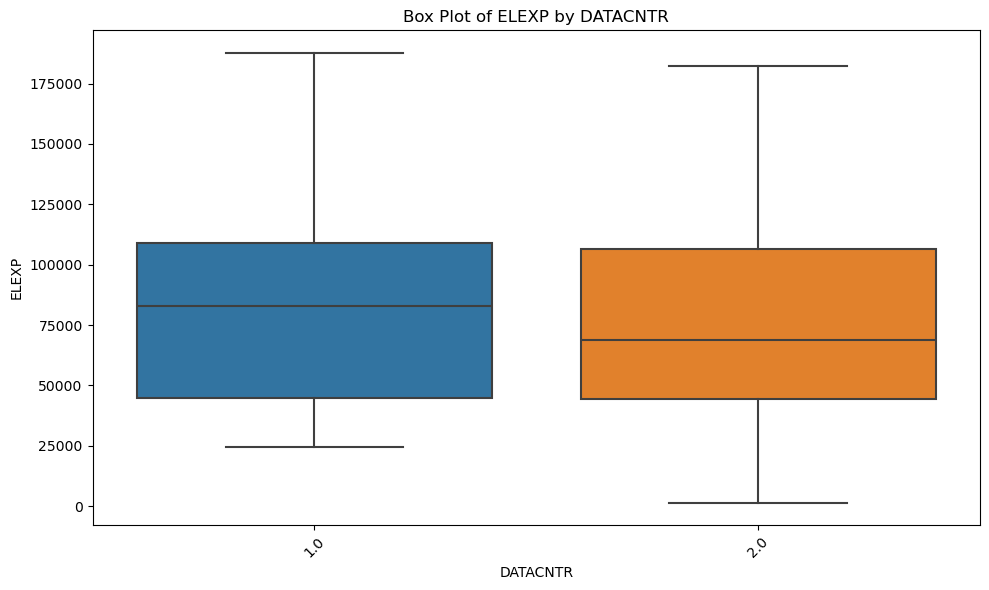

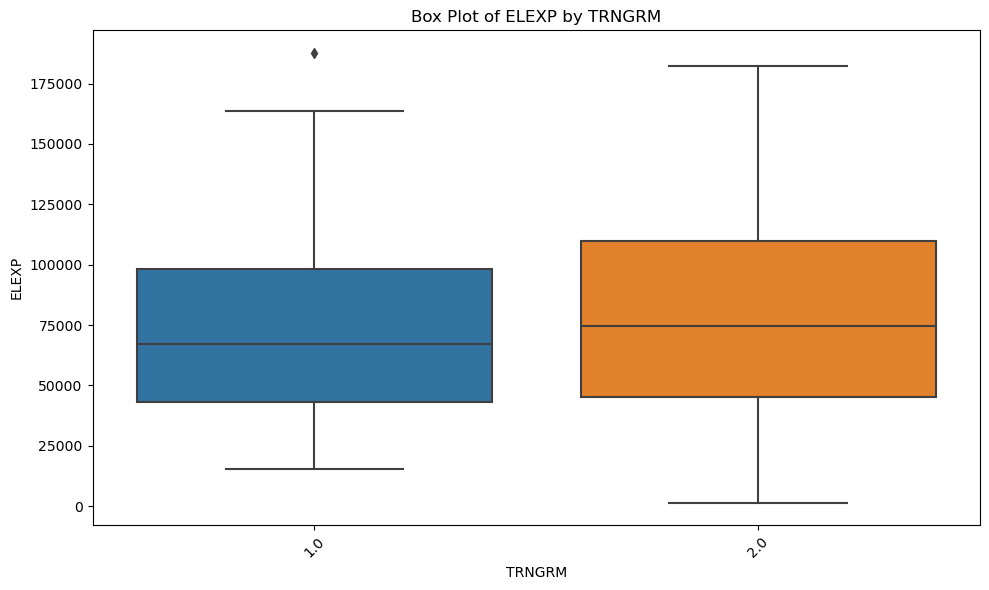

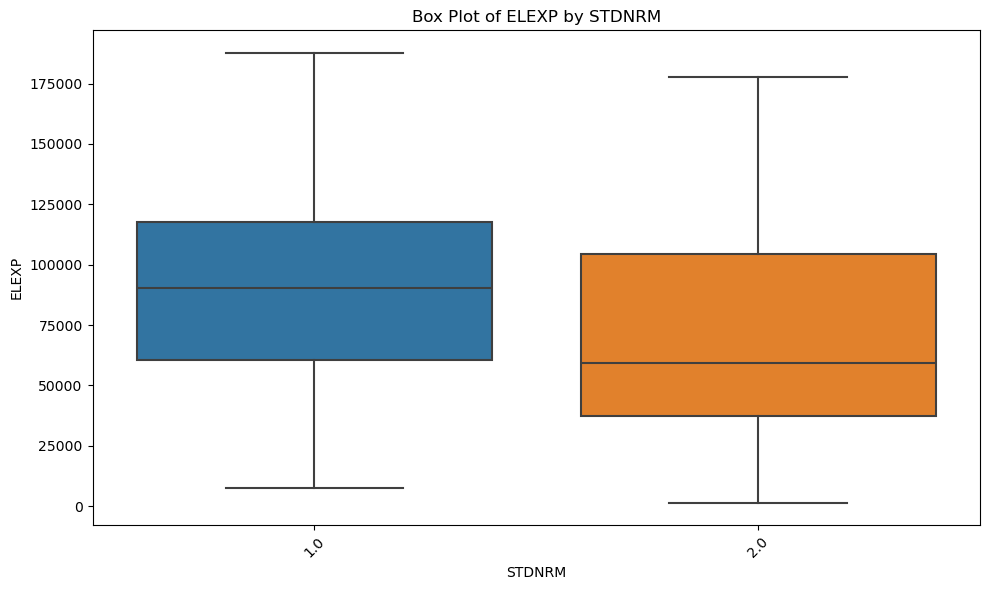

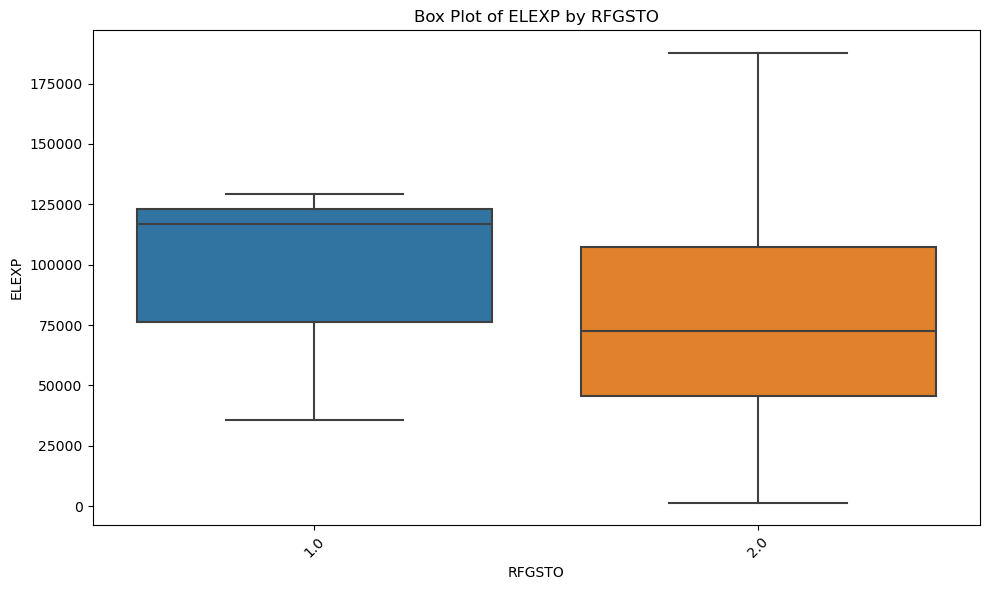

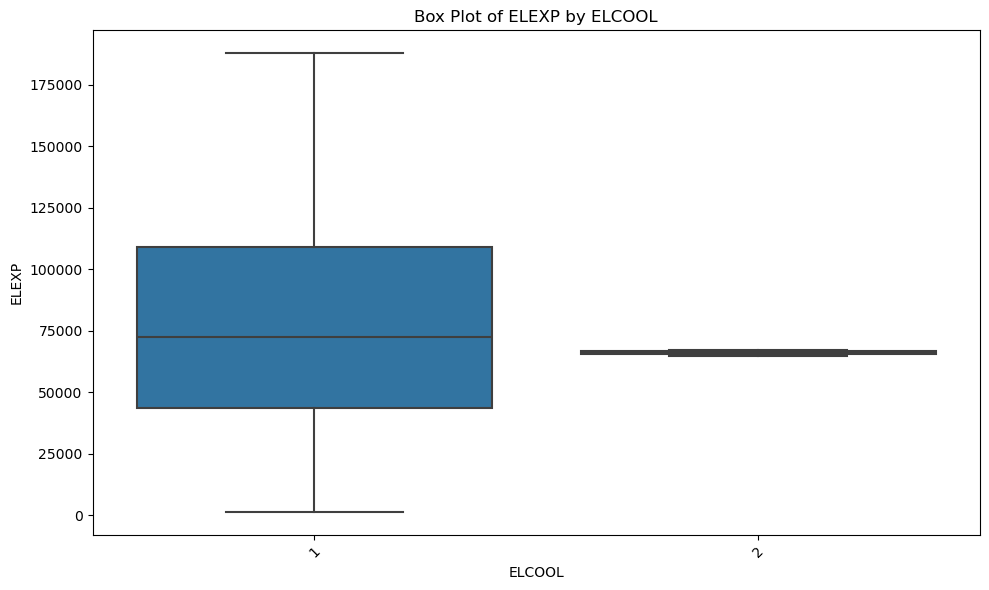

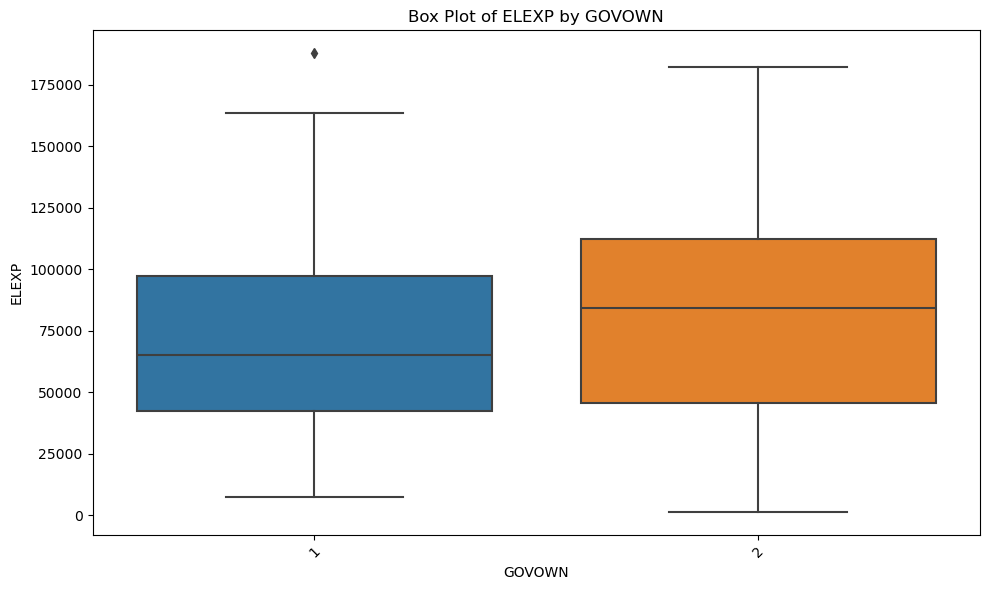

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume `cat_cols` contains the list of categorical columns
# Assume `num_col` is the numerical column for box plots
num_col = 'ELEXP'       # Replace with your actual numerical column

# Iterate through each categorical column
for cat_col in cat_cols:
    plt.figure(figsize=(10, 6))  # Set figure size
    sns.boxplot(x=cat_col, y=num_col, data=df)
    plt.title(f"Box Plot of {num_col} by {cat_col}")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()
    plt.show()


In [90]:
from scipy.stats import f_oneway

target_col = "ELEXP"
for cat_col in cat_cols:
    # Group numerical target by each category in the categorical column
    groups = [df[target_col][df[cat_col] == category] for category in df[cat_col].unique()]
    
    # Perform ANOVA
    f_stat, p_value = f_oneway(*groups)
    
    # Display Results
    print(f"ANOVA results for {cat_col}:")
    print(f"F-statistic: {f_stat:.4f}, P-value: {p_value:.4f}")
    print("-" * 40)


ANOVA results for DATACNTR:
F-statistic: 0.3604, P-value: 0.5497
----------------------------------------
ANOVA results for TRNGRM:
F-statistic: 0.0489, P-value: 0.8255
----------------------------------------
ANOVA results for STDNRM:
F-statistic: 4.7844, P-value: 0.0311
----------------------------------------
ANOVA results for RFGSTO:
F-statistic: nan, P-value: nan
----------------------------------------
ANOVA results for ELCOOL:
F-statistic: 0.1507, P-value: 0.6988
----------------------------------------
ANOVA results for GOVOWN:
F-statistic: 1.0793, P-value: 0.3015
----------------------------------------


/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


In [91]:
from scipy.stats import kruskal


for cat_col in cat_cols:
    # Group the target variable by each category in the categorical column
    groups = [df[target_col][df[cat_col] == category] for category in df[cat_col].unique()]
    
    # Perform Kruskal-Wallis Test
    h_stat, p_value = kruskal(*groups)
    
    # Display Results
    print(f"Kruskal-Wallis Test results for {cat_col}:")
    print(f"H-statistic: {h_stat:.4f}, P-value: {p_value:.4f}")
    print("-" * 40)


Kruskal-Wallis Test results for DATACNTR:
H-statistic: 0.1790, P-value: 0.6722
----------------------------------------
Kruskal-Wallis Test results for TRNGRM:
H-statistic: 0.1043, P-value: 0.7467
----------------------------------------
Kruskal-Wallis Test results for STDNRM:
H-statistic: 4.6622, P-value: 0.0308
----------------------------------------
Kruskal-Wallis Test results for RFGSTO:
H-statistic: nan, P-value: nan
----------------------------------------
Kruskal-Wallis Test results for ELCOOL:
H-statistic: 0.0511, P-value: 0.8211
----------------------------------------
Kruskal-Wallis Test results for GOVOWN:
H-statistic: 1.2415, P-value: 0.2652
----------------------------------------


### Regression analysis

In [96]:
# cat_cols = ["DATACNTR", "TRNGRM", "STDNRM", "LGOFFDEV", "SMOFFDEV", "SERVER", "LAPTOP", "RFGSTO", "ELCOOL","GOVOWN"]
# cont_cols = ["PCTERMN", "LAPTPN", "TABLETN","SERVERN", "LGOFFDEVN", "SMOFFDEVN", "WBOARDSN", "COOLP", "ELEXP"]
# Replace NaN with median for all numerical columns
df[cont_cols] = df[cont_cols].apply(lambda col: col.fillna(col.median()))

# Replace NaN with the mode (most frequent category) for categorical columns
df[cat_cols] = df[cat_cols].apply(lambda col: col.fillna(col.mode()[0]))





In [99]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

# Assuming you already have df, cont_cols, cat_cols, and target_col defined

# Prepare the features (X) and target (y)
X = df[cont_cols + cat_cols].drop(columns=[target_col])
y = df[target_col]

# Encode categorical variables if necessary (using one-hot encoding, for example)
X_encoded = pd.get_dummies(X, drop_first=True)  # Create dummy variables for categorical features

# Add an intercept (constant) to the model
X_encoded = sm.add_constant(X_encoded)

# Fit the model using statsmodels
model = sm.OLS(y, X_encoded)
results = model.fit()

# Print the summary of the model (which includes p-values)
print(results.summary())

# Extract the p-values for each feature and interaction term
p_values = results.pvalues
print(p_values)


                            OLS Regression Results                            
Dep. Variable:                  ELEXP   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     2.264
Date:                Fri, 29 Nov 2024   Prob (F-statistic):             0.0115
Time:                        13:20:51   Log-Likelihood:                -1169.3
No. Observations:                  98   AIC:                             2369.
Df Residuals:                      83   BIC:                             2407.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.885e+04   6.76e+04      0.870      0.3

Mean Squared Error: 1604464978.5669
R² Score: 0.0992


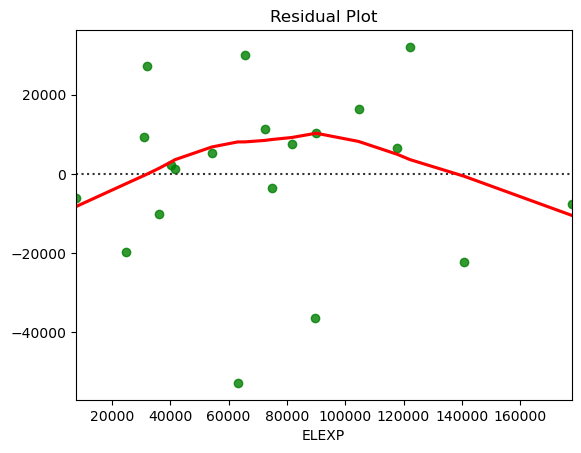

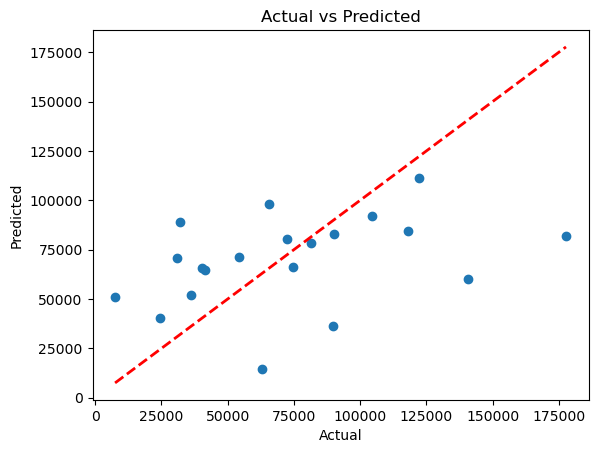

In [98]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

X = df[cont_cols+cat_cols].drop(columns=[target_col])  # Features (independent variables)
y = df[target_col]  # Target (dependent variable)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

sns.residplot(x=y_test, y=y_pred, lowess=True, color="g", line_kws={'color': 'red'})
plt.title("Residual Plot")
plt.show()

plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()
